In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
df = pd.read_csv("/content/gdrive/MyDrive/tripadvisor_hotel_reviews.csv")

In [3]:
print(df.head())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None


In [5]:
print(df.describe())

             Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000


In [6]:
print(df.isnull().sum())

Review    0
Rating    0
dtype: int64


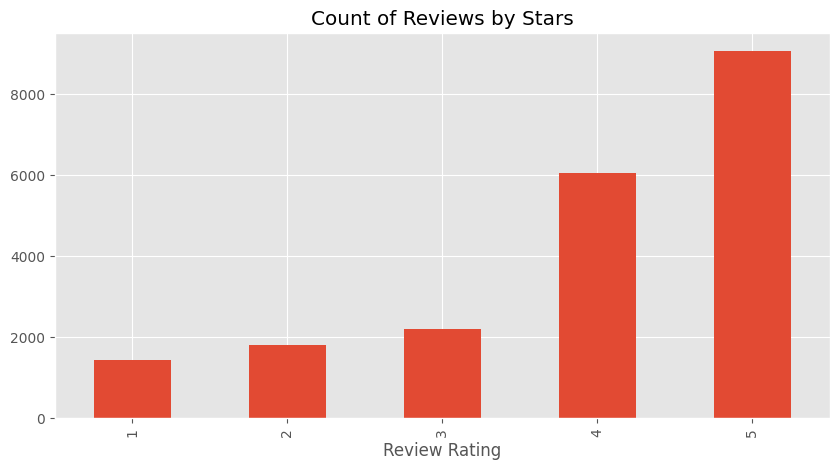

In [7]:
xlabel = df["Rating"].value_counts().sort_index().plot(kind="bar",
                                              title="Count of Reviews by Stars",
                                              figsize=(10, 5))
xlabel.set_xlabel("Review Rating")
plt.show()

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [9]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
device = "cuda:0"
tokenizer = AutoTokenizer.from_pretrained(MODEL, clean_up_tokenization_spaces=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [10]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt", truncation=True, max_length=512).to(device)
    output = model(**encoded_text)
    scores = output[0][0].cpu().detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg" : scores[0],
        "roberta_neu" : scores[1],
        "roberta_pos" : scores[2]
    }
    return scores_dict

In [12]:
from tqdm.notebook import tqdm

res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    review = row["Review"]
    roberta_result = polarity_scores_roberta(review)
    res[i] = {**roberta_result}

  0%|          | 0/20491 [00:00<?, ?it/s]

In [13]:
df = pd.concat([pd.DataFrame(res).T, df], axis=1)
df.columns

Index(['roberta_neg', 'roberta_neu', 'roberta_pos', 'Review', 'Rating'], dtype='object')

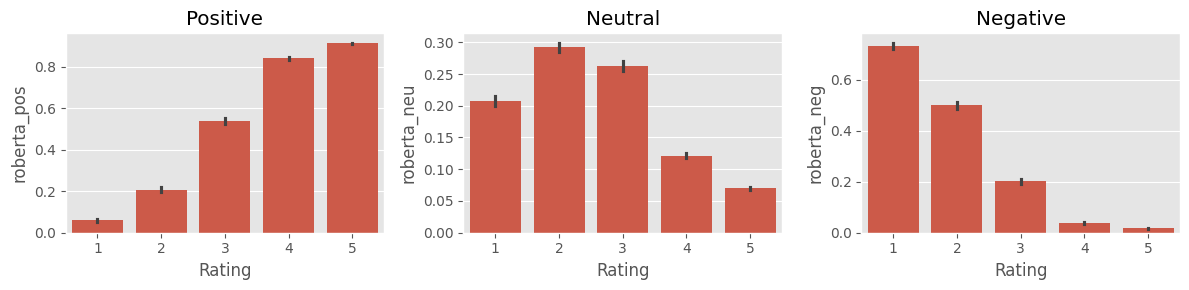

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x="Rating", y="roberta_pos", ax=axs[0])
sns.barplot(data=df, x="Rating", y="roberta_neu", ax=axs[1])
sns.barplot(data=df, x="Rating", y="roberta_neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

In [18]:
# Rating of 1, Highest roberta_pos score

df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

'love, family travelled riu bambu twice august 2001 march 2007, love riu bambu, amazing place stay, worrying negative comments ignore, riu bambu amazing just like riu hotel chain fantastic, mom actually travelling riu vallarta week puerto vallarta, riu riu palace cabo san lucas riu cancun says entertainment 1 beach service..its amazing want good entertainment riu bambu domenican no, palaces bambu night getting best entertainment overall riu bambu amazing going return year going try new, likely march break returning group friends enjoy stay,  '

In [21]:
# Rating of 5, Highest roberta_neg score

df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

"ask frequent traveler dallas destinations experienced usual-come-with-the-gig travel snafus, defacto, luggage flight vancouver know ditty bag essentials better hotel know hotel room 15 minutes, does n't better that.i disappointed restaurant adjustments, sushi bar outstanding, food outstanding miss sushi,  "

In [26]:
def classify_sentiment(row):
    if row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 'Positive'
    elif row['roberta_neg'] > row['roberta_neu']:
        return 'Negative'
    else:
        return 'Neutral'

df['predicted_sentiment'] = df.apply(classify_sentiment, axis=1)

In [24]:
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['true_sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

In [27]:
roberta_accuracy = (df['predicted_sentiment'] == df['true_sentiment']).mean()
print(f"Roberta Classification Accuracy: {roberta_accuracy * 100:.2f}%")

Roberta Classification Accuracy: 83.67%
